# Style Transfer: A PyTorch Implementation
This project is about performing style transfer by iteratively updating the pixels of an image both to take on the spatial structure of one image whilst preserving a style taken from another image. This implementation is based off of the paper (https://arxiv.org/pdf/1508.06576.pdf).

The model takes in three inputs. An input image, a content image, and a style image. We would like to cast the spatial content of the content image and the style of the style image onto the input image.

The main idea is to develop a loss function that treats the content (spatial) and style of the image separately. Given an input image, the loss function will tell us how similar the spatial content is to the content image and how similar the style is to the style image is. By minimising this loss function with respect to this input image, we will end up with an image that preserves both the content and the style of the two other images. 

### Content Loss
Given the input image and the content image, we would like to change the pixels of the input image to look more like the content image. This can be easily done by minimising the mean-squared error between the pixels of the input image and the content image, right? Unfortunately, by doing this, the input image would also take on the general style of the content image since you are trying to copy it pixel for pixel. To ignore the style component, we can extract the high-level feature representations of a layer from a pre-trained CNN. These feature representation capture the spatial information of the image without containing the style information. The problem now becomes minimising the mean-squared error between the feature representations of a layer from a pre-trained CNN for both the input image and the content image. 

Let $X_\text{input}$ and $X_\text{content}$ be the input image and content image respectively. The feature maps extracted from the $L^{th}$ layer of the CNN will be denoted as $F^{L}_{X_\text{input}}$ and $F^{L}_{X_\text{content}}$. The content loss can then be expressed as: 

$$L_\text{content} = MSE(F^{L}_{X_{\text{input}}}, F^{L}_{X_\text{content}}) = \frac{1}{2} (F^{L}_{X_{\text{input}}} - F^{L}_{X_\text{content}})^2$$

### Style Loss
Given the input image and the style image, we would like to change the pixels of the input image to look more like the style image. Similarly, if we were to do this by minmising the mean-squared error between the pixels of the input image and the content image, the input image would also learn the spatial structure of the style image, which isn't desirable. Again, the trick is to pass the style image through a pre-trained CNN to extract high-level feature representations. Unfortunately, it's not as easy as just minimising the mean-squared error between the feature representations of the input image and the style image, as this would just cast the spatial information of the style image. We need a way of extracting the style information from the style image. 

One way of doing this is by defining the 'Gram Matrix'. Given the $L^{th}$ layer feature maps of the style image ($F^{L}_{X_{\text{style}}}$), the gram matrix is just the covariance matrix between all the feature maps in that layer. 

Let $f^{L}_i$ be the $i^{th}$ feature map of the $L^{th}$ layer, the gram matrix is then defined as

$$G = \sum_j^k f^{L}_j (f^{L}_k)^T$$

This gives a general measure on the feature distribution of the image, which in turn gives us an idea of the style of the image.

The style loss can then be defined by the mean-squared error between the gram matrices of the feature maps in layer L for the input image and the style image. 

$$L_\text{style} = MSE(G^{L}_{\text{input}} - G^{L}_{\text{style}}) = \frac{1}{2}(G^{L}_{\text{input}} - G^{L}_{\text{style}})^2$$

### Total Loss
The total loss then becomes the weighted combination of the content loss and the style loss. 

$$L_\text{total} = \alpha L_{\text{content}} + \beta L_{\text{style}}$$
where the parameters $\alpha$ and $\beta$ control the importance of the content and style of the input image respectively. The larger the $\beta$ parameter, the stronger the style will be applied to the image.

## Mount Google Drive
The demonstrations will be run on Colaboratory (https://colab.research.google.com/), where the models can run and train on a GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change path to access modules within Google Drive
import sys
sys.path.append('/content/drive/My Drive/style_transfer/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset
In this notebook, I will demonstrate style transfer on three different images, using three different styles. The three different styles are taken from famous artworks: 'Starry Night', 'The Scream', and 'Face in a Midday'. 

The three content images and three style images can be seen below.

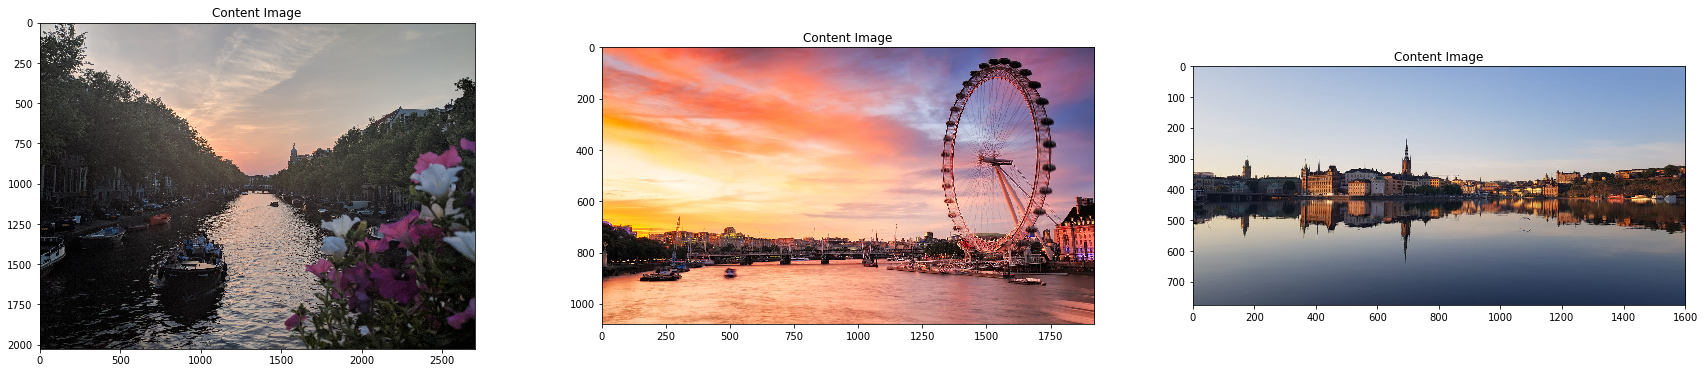

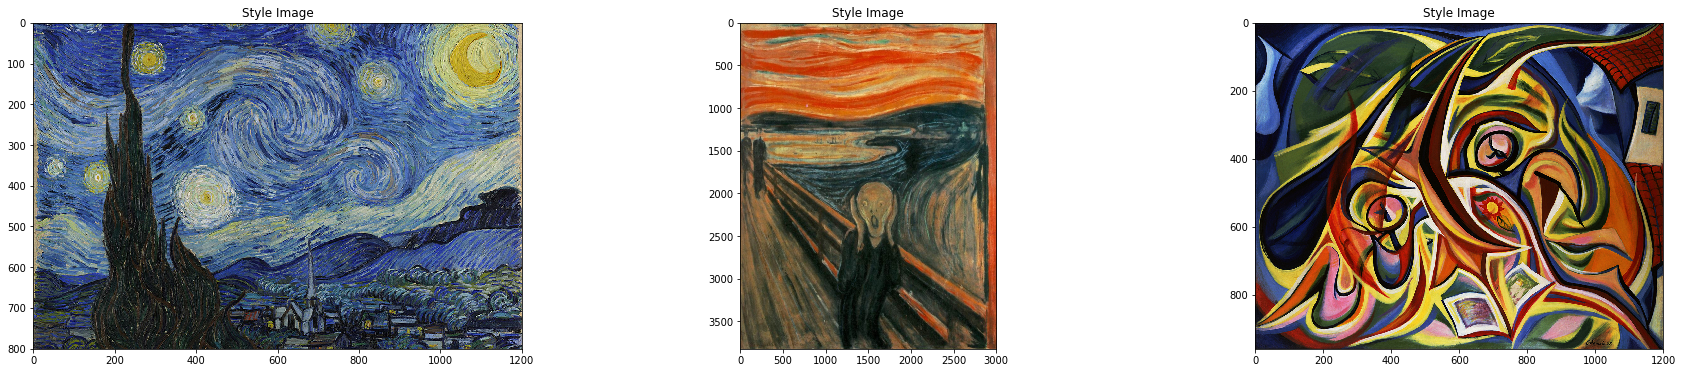

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

content_image_paths = ['/content/drive/My Drive/style_transfer/images/content/amsterdam_canal.jpg', '/content/drive/My Drive/style_transfer/images/content/london-eye-wallpaper_may_2018.jpg', '/content/drive/My Drive/style_transfer/images/content/stockholm.jpg']
style_image_paths = ['/content/drive/My Drive/style_transfer/images/style/Vincent-van-Gogh-The-Starry-Night-1889-2.jpg', '/content/drive/My Drive/style_transfer/images/style/The_Scream.jpg', '/content/drive/My Drive/style_transfer/images/style/face_in_a_midday.jpg']


content_fig, content_ax = plt.subplots(1, 3, figsize=(30, 6))

for i, path in enumerate(content_image_paths):
  image = Image.open(path)
  content_ax[i].imshow(image)
  content_ax[i].set_title('Content Image')

plt.show()

style_fig, style_ax = plt.subplots(1, 3, figsize=(30, 6))

for i, path in enumerate(style_image_paths):
  image = Image.open(path)
  style_ax[i].imshow(image)
  style_ax[i].set_title('Style Image')

plt.show()
  
  

## Model: Amsterdam Canal
The first style transfer to take place will be between the picture of the Amsterdam Canal and the three different styles. 

First, we need to set up the parameters of the model:
    - the paths to the images
    - the convolutional layers that the features will be extracted from for both content and style.
    - content and style weights
    - image scale factor
    - number of iterations
    - early stopping criteria

In [0]:
# Define content image paths and style image paths
content_image_paths = ['/content/drive/My Drive/style_transfer/images/content/amsterdam_canal.jpg']
style_image_paths = ['/content/drive/My Drive/style_transfer/images/style/Vincent-van-Gogh-The-Starry-Night-1889-2.jpg', '/content/drive/My Drive/style_transfer/images/style/The_Scream.jpg', '/content/drive/My Drive/style_transfer/images/style/face_in_a_midday.jpg']

# Define content layers and style layers within the VGG network.
content_layer_indices = [13]
style_layer_indices = [1, 3, 6, 8, 11, 13, 15, 17, 24]

# Instantiate parameters for style transfer
image_scale = 1. / 8
content_weight = 1
style_weight = 5e5
iterations = 1000
early_stopping = 20

### Train the model 

In [4]:
from model import StyleTransfer

model = StyleTransfer()

output_images_amsterdam = model.transfer(
                     content_image_paths, 
                     style_image_paths, 
                     content_layer_indices, 
                     style_layer_indices,
                     content_weight=content_weight,
                     style_weight=style_weight,                
                     image_scale=image_scale,
                     iterations=iterations,
                     early_stopping=early_stopping
              )

Iteration: 1 (ES: 0)	 Content Loss: 0.0000	 Style Loss: 0.0224692	 Total Loss: 11234.6113281
Iteration: 100 (ES: 0)	 Content Loss: 20.5501	 Style Loss: 0.0000406	 Total Loss: 40.8270874
Iteration: 200 (ES: 0)	 Content Loss: 20.2351	 Style Loss: 0.0000171	 Total Loss: 28.7849579
Iteration: 300 (ES: 1)	 Content Loss: 19.7582	 Style Loss: 0.0000120	 Total Loss: 25.7528095
Iteration: 400 (ES: 1)	 Content Loss: 19.3943	 Style Loss: 0.0000105	 Total Loss: 24.6273117
Iteration: 500 (ES: 3)	 Content Loss: 19.2164	 Style Loss: 0.0000083	 Total Loss: 23.3850422
Iteration: 600 (ES: 5)	 Content Loss: 19.0343	 Style Loss: 0.0000074	 Total Loss: 22.7533226


## Model: London Eye

In [0]:
# Define content image paths and style image paths
content_image_paths = ['/content/drive/My Drive/style_transfer/images/content/london-eye-wallpaper_may_2018.jpg']
style_image_paths = ['/content/drive/My Drive/style_transfer/images/style/Vincent-van-Gogh-The-Starry-Night-1889-2.jpg', '/content/drive/My Drive/style_transfer/images/style/The_Scream.jpg', '/content/drive/My Drive/style_transfer/images/style/face_in_a_midday.jpg']

# Define content layers and style layers within the VGG network.
content_layer_indices = [13]
style_layer_indices = [1, 3, 6, 8, 11, 13, 15, 17, 24]

# Instantiate parameters for style transfer
image_scale = 1. / 6

### Train the model

In [6]:
model = StyleTransfer()

output_images_london = model.transfer(
                     content_image_paths, 
                     style_image_paths, 
                     content_layer_indices, 
                     style_layer_indices,
                     content_weight=content_weight,
                     style_weight=style_weight,                
                     image_scale=image_scale,
                     iterations=iterations,
                     early_stopping=early_stopping
              )

Iteration: 1 (ES: 0)	 Content Loss: 0.0000	 Style Loss: 0.0248003	 Total Loss: 12400.1679688
Iteration: 100 (ES: 0)	 Content Loss: 21.0748	 Style Loss: 0.0000658	 Total Loss: 53.9602203
Iteration: 200 (ES: 0)	 Content Loss: 21.2001	 Style Loss: 0.0000296	 Total Loss: 35.9969940
Iteration: 300 (ES: 0)	 Content Loss: 20.8195	 Style Loss: 0.0000213	 Total Loss: 31.4777832
Iteration: 400 (ES: 0)	 Content Loss: 20.5269	 Style Loss: 0.0000173	 Total Loss: 29.1585808
Iteration: 500 (ES: 0)	 Content Loss: 20.3248	 Style Loss: 0.0000149	 Total Loss: 27.7705994
Iteration: 600 (ES: 0)	 Content Loss: 20.1579	 Style Loss: 0.0000133	 Total Loss: 26.7868309
Iteration: 700 (ES: 10)	 Content Loss: 20.0353	 Style Loss: 0.0000125	 Total Loss: 26.2742271
Iteration: 800 (ES: 0)	 Content Loss: 19.8805	 Style Loss: 0.0000116	 Total Loss: 25.6692181
Iteration: 900 (ES: 0)	 Content Loss: 19.7751	 Style Loss: 0.0000111	 Total Loss: 25.3454037


## Model: Stockholm

In [0]:
# Define content image paths and style image paths
content_image_paths = ['/content/drive/My Drive/style_transfer/images/content/stockholm.jpg']

# Instantiate parameters for style transfer
image_scale = 1. / 4

### Train the model

In [8]:
model = StyleTransfer()

output_images_stockholm = model.transfer(
                     content_image_paths, 
                     style_image_paths, 
                     content_layer_indices, 
                     style_layer_indices,
                     content_weight=content_weight,
                     style_weight=style_weight,                
                     image_scale=image_scale,
                     iterations=iterations,
                     early_stopping=early_stopping
              )

Iteration: 1 (ES: 0)	 Content Loss: 0.0000	 Style Loss: 0.0239301	 Total Loss: 11965.0458984
Iteration: 100 (ES: 0)	 Content Loss: 23.8728	 Style Loss: 0.0000515	 Total Loss: 49.6284142
Iteration: 200 (ES: 0)	 Content Loss: 23.3766	 Style Loss: 0.0000225	 Total Loss: 34.6476059
Iteration: 300 (ES: 0)	 Content Loss: 22.8174	 Style Loss: 0.0000158	 Total Loss: 30.6948147
Iteration: 400 (ES: 2)	 Content Loss: 22.3714	 Style Loss: 0.0000127	 Total Loss: 28.7436275
Iteration: 500 (ES: 0)	 Content Loss: 22.1271	 Style Loss: 0.0000108	 Total Loss: 27.5188580
Iteration: 600 (ES: 1)	 Content Loss: 21.9044	 Style Loss: 0.0000096	 Total Loss: 26.7179794


## Display the style transferred images

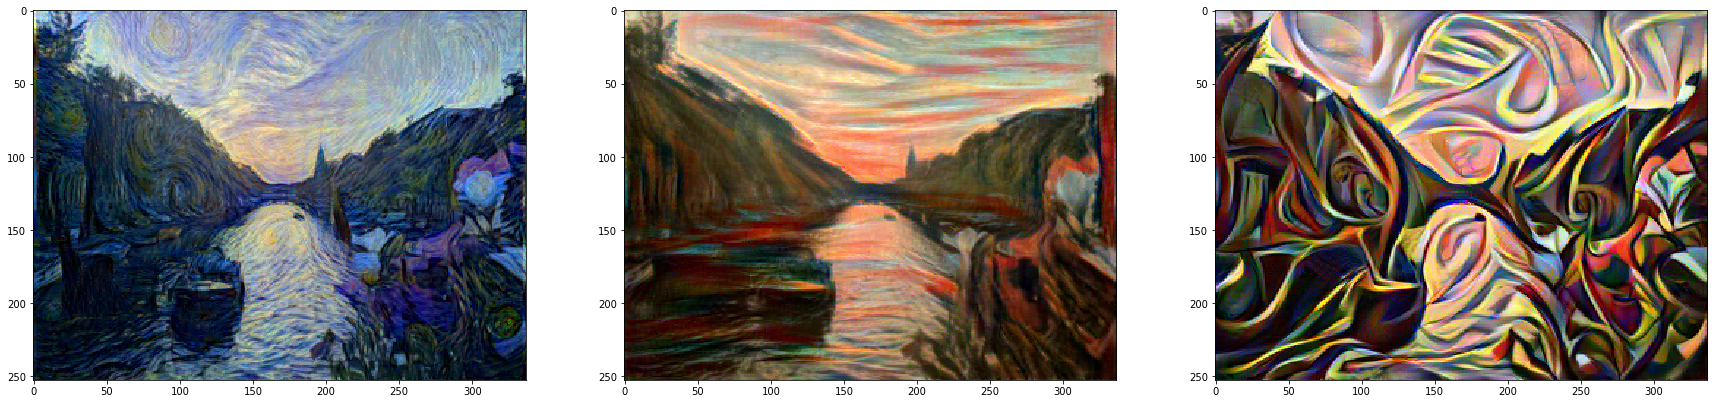

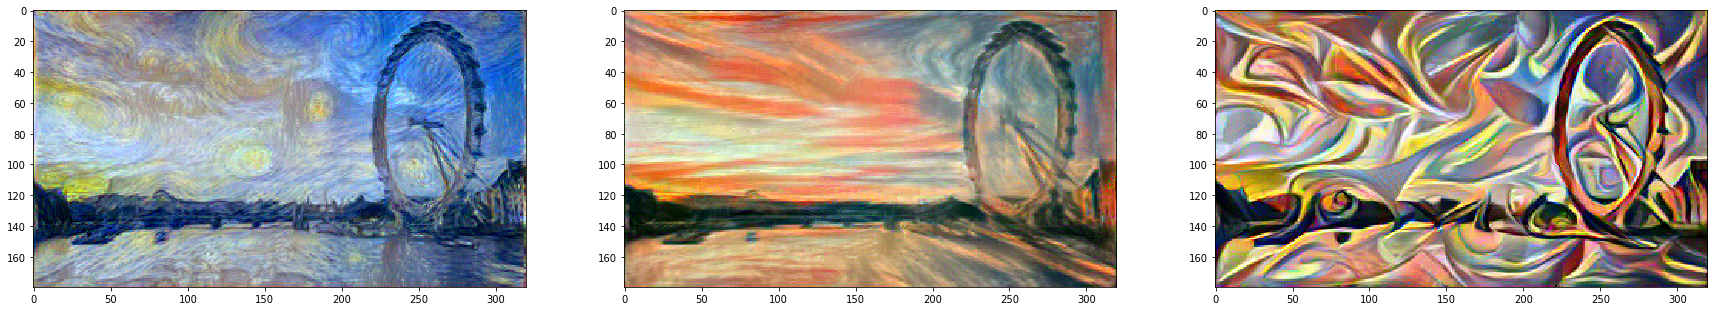

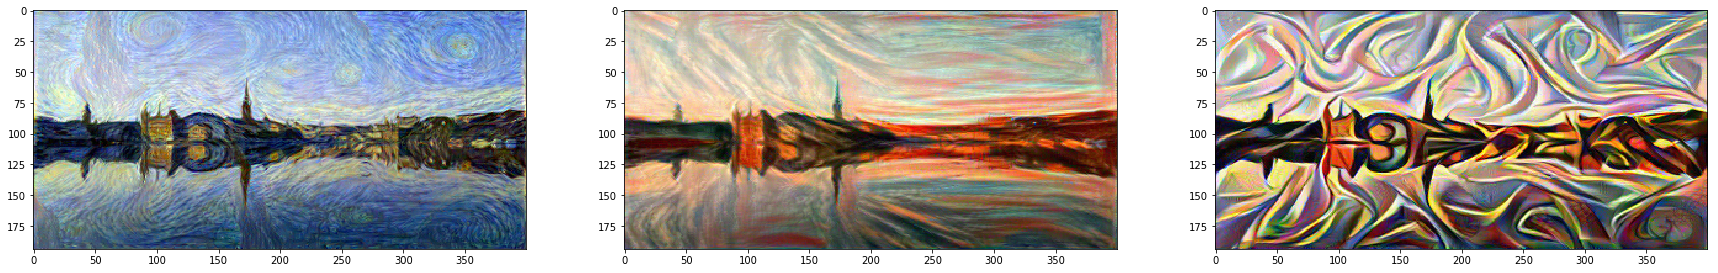

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

convert_tensor_to_PILImage = transforms.ToPILImage()

fig, ax = plt.subplots(1, 3, figsize=(30, 7))
for i in range(3):
  ax[i].imshow(convert_tensor_to_PILImage(output_images_amsterdam[i].detach().cpu()))

fig, ax = plt.subplots(1, 3, figsize=(30, 8))
for i in range(3):
  ax[i].imshow(convert_tensor_to_PILImage(output_images_london[i].detach().cpu()))
  

fig, ax = plt.subplots(1, 3, figsize=(30, 9))
for i in range(3):
  ax[i].imshow(convert_tensor_to_PILImage(output_images_stockholm[i].detach().cpu()))
  